Using device: cuda


100%|██████████| 170M/170M [00:05<00:00, 30.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1/20, Loss: 1.9038, Train Acc: 30.48%, Val Acc: 40.66%
Epoch 2/20, Loss: 1.7356, Train Acc: 38.50%, Val Acc: 43.38%
Epoch 3/20, Loss: 1.6545, Train Acc: 41.77%, Val Acc: 46.28%
Epoch 4/20, Loss: 1.6083, Train Acc: 43.46%, Val Acc: 46.87%
Epoch 5/20, Loss: 1.5645, Train Acc: 45.05%, Val Acc: 49.11%
Epoch 6/20, Loss: 1.5306, Train Acc: 46.70%, Val Acc: 49.64%
Epoch 7/20, Loss: 1.4982, Train Acc: 47.68%, Val Acc: 49.36%
Epoch 8/20, Loss: 1.4724, Train Acc: 48.87%, Val Acc: 50.28%
Epoch 9/20, Loss: 1.4517, Train Acc: 49.28%, Val Acc: 50.33%
Epoch 10/20, Loss: 1.4317, Train Acc: 50.20%, Val Acc: 50.97%
Epoch 11/20, Loss: 1.4112, Train Acc: 50.62%, Val Acc: 50.82%
Epoch 12/20, Loss: 1.3916, Train Acc: 51.47%, Val Acc: 51.79%
Epoch 13/20, Loss: 1.3758, Train Acc: 52.03%, Val Acc: 51.99%
Epoch 14/20, Loss: 1.3593, Train Acc: 52.57%, Val Acc: 51.39%
Epoch 15/20, Loss: 1.3525, Train Acc: 52.78%, Val Ac

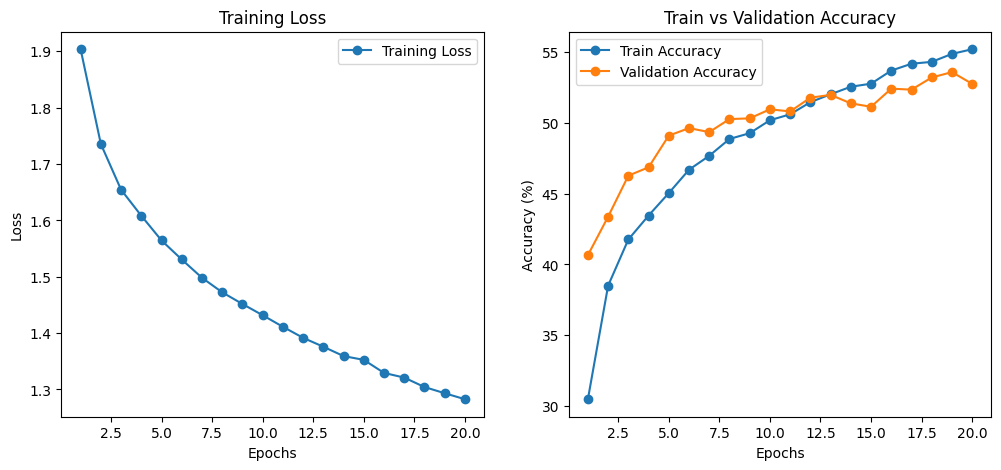


Classification Report:
               precision    recall  f1-score   support

    airplane       0.60      0.57      0.58      1000
  automobile       0.72      0.61      0.66      1000
        bird       0.43      0.32      0.36      1000
         cat       0.34      0.39      0.36      1000
        deer       0.40      0.55      0.46      1000
         dog       0.50      0.26      0.34      1000
        frog       0.54      0.64      0.58      1000
       horse       0.64      0.58      0.61      1000
        ship       0.55      0.79      0.65      1000
       truck       0.64      0.57      0.60      1000

    accuracy                           0.53     10000
   macro avg       0.54      0.53      0.52     10000
weighted avg       0.54      0.53      0.52     10000



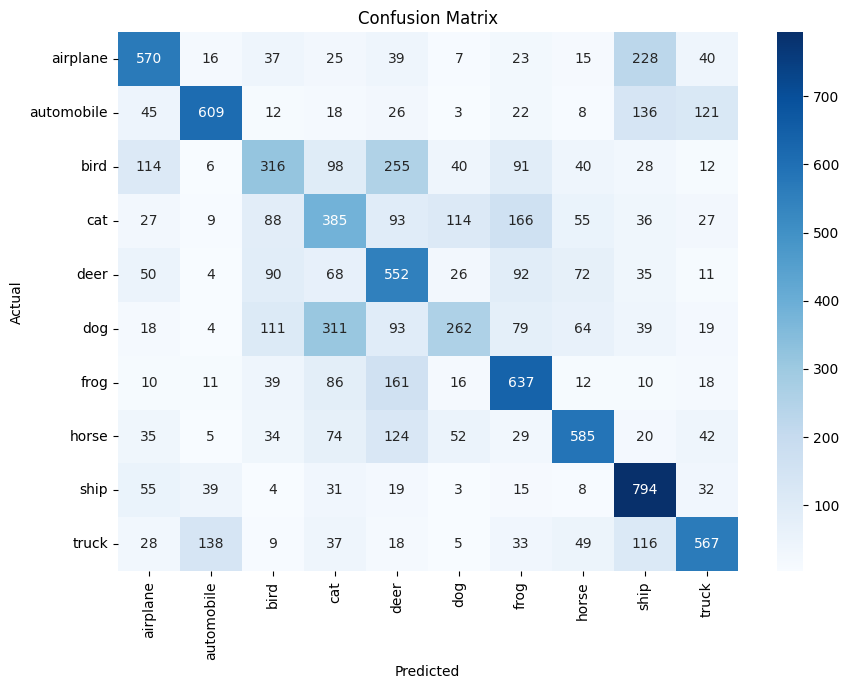


Model saved as 'deep_mlp_cifar10.pth'.


In [2]:
#Complex_b
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#####load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

#define the deeper MLP model
class DeepMLP(nn.Module):
    def __init__(self, input_dim=32*32*3, hidden_dims=[1024, 512, 256, 128, 64], output_dim=10):
        super(DeepMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.fc4 = nn.Linear(hidden_dims[2], hidden_dims[3])
        self.fc5 = nn.Linear(hidden_dims[3], hidden_dims[4])
        self.fc6 = nn.Linear(hidden_dims[4], output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

#initializiatiom
model = DeepMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 20
train_losses, train_accuracies, val_accuracies = [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

    #validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%")

#plot training and validation results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.show()

#evaluate the model on the test set
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

#confusion matrix and classification
conf_matrix = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=trainset.classes)

print("\nClassification Report:\n", report)

# Plot
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


torch.save(model.state_dict(), "deep_mlp_cifar10.pth")
print("\nModel saved as 'deep_mlp_cifar10.pth'.")
